# Entender o Problema

- Objetivo do Problema:
    - Predição de qual país será o primeiro destino de reserva de um novo usuário;
    - Porque?
        - Qual o tipo de modelo de negócio do Airbnb?
            - Marketplace (conecta pessoas que oferecem acomodação, com pessoas que estão procurando acomodação)
            - Oferta (pessoas oferecendo acomodação)
                - Tamanho do portifólio
                - Diversisdade/Densidade de Portfólio
                - preço Médio
            - Demanda (pessoas procurando acomodação)
                - Número de Usuários
                - LTV (Lifetime Value)
                - CAC ( Client Acquisition Cost)

        Gross Revenue = (Fee*Numero cliente) - CAC

- Proposta de Solução:
    - Modelo de Previsão do primeiro destino de um novo usuário
    - 1.0. Predições salvas em uma tabela do banco de dados
    - 2.0. API
        - Input: usuário e suas características
        - Output: usuário e suas características com a predição de destino

# <font color='red'>Ciclo 01: End to End</font>

# 0.0. Imports

In [199]:
import random
import pandas               as pd
import numpy                as np
import seaborn              as sns
import matplotlib.pyplot    as plt
from sklearn.model_selection    import train_test_split, StratifiedKFold
from sklearn    import preprocessing as pp
from sklearn    import metrics       as m
from scipy      import stats         as ss

from imblearn import under_sampling  as us
from imblearn import over_sampling   as overs
from imblearn import combine         as comb 

from pandas_profiling import ProfileReport

from keras import models as ml
from keras.layers import Dense

import tensorflow as tf

from scikitplot import metrics       as mt

%matplotlib inline


## 0.1. Helper Functions

In [200]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    # \chi ^{2} is derived from Pearson's chi-squared test
    chi2 = ss.chi2_contingency(cm)[0]
    phi2 = chi2/n
    phi2corr  = max(0, phi2 - (k-1)*(r-1)/(n-1))

    kcorr = k - ((k-1)**2)/(n-1)
    rcorr = r - ((r-1)**2)/(n-1)

    # Varia de 0 a 1
    return np.sqrt(phi2corr/min(kcorr-1, rcorr-1))

## 0.2. Loading Data

In [201]:
df_users_raw = pd.read_csv('../data/train_users_2.csv', low_memory=True)
df_users_raw.shape

(213451, 16)

In [202]:
df_sessions = pd.read_csv('../data/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0 Data Description

In [203]:
df1 = df_users_raw.copy()

## 1.1. Data Dimension

In [204]:
print('Number of rows {}'.format(df1.shape[0]))
print('Number of columns {}'.format(df1.shape[1]))

Number of rows 213451
Number of columns 16


In [205]:
print('Number of rows {}'.format(df_sessions.shape[0]))
print('Number of columns {}'.format(df_sessions.shape[1]))

Number of rows 10567737
Number of columns 6


## 1.2. Data Types

In [206]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [207]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check NAs

In [208]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [209]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

/home/leonam/anaconda3/envs/airbnb/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='secs_elapsed', ylabel='Density'>

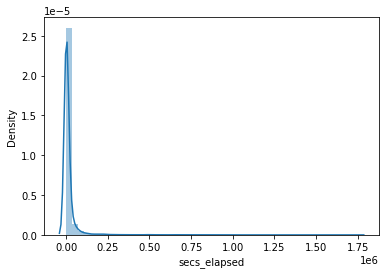

In [210]:
sns.distplot(df_sessions['secs_elapsed'].sample(10000))

## 1.4. Fillout NAs

In [211]:
# remiove missing values
# df1 = df1.dropna()


# =============== User ===================

# date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

# age - NA está distribuido entre as classes
# Distribuição de age se parece com uma normal
# df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = int(df1['age'].mean())
df1['age'] = df1['age'].fillna(avg_age)

# first_affiliate_tracked - fazer replacement de dados categoricos é perigoso com chance de enviesar o modelo
df1 = df1[~df1['first_affiliate_tracked'].isna()]

# =============== Sessions ===================
# Como df_sessions possui um número muito grande amostras (10567737), serão removidas todas as amostras 
# que possuem dados NA 

# user_id          0.3%
df_sessions = df_sessions[df_sessions['user_id'].notna()]

# action           0.7%
df_sessions = df_sessions[df_sessions['action'].notna()]

# action_type      10.6570%
df_sessions = df_sessions[df_sessions['action_type'].notna()]

# action_detail    10.6570%
df_sessions = df_sessions[df_sessions['action_detail'].notna()]

# secs_elapsed     1.2872%
df_sessions = df_sessions[df_sessions['secs_elapsed'].notna()]


## 1.5. Change Types

In [212]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [213]:
# date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'], format='%Y-%m-%d')

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'], format='%Y-%m-%d')

# age
df1['age'] = df1['age'].astype(int)

## 1.6. Check Balanced Data

In [214]:
# response variable is the columns country_destination
df1['country_destination'].value_counts()

NDF      120216
US        61067
other      9981
FR         4899
IT         2791
GB         2295
ES         2213
CA         1391
DE         1041
NL          751
AU          527
PT          214
Name: country_destination, dtype: int64

## 1.7. Descriptive Analysis


In [215]:
# Users
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

# Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.7.1 Numerical Attributes

#### 1.7.1.2. Users

In [216]:
# Users
# Central Tendency - Mean, Median, 
ct1 = pd.DataFrame(num_attributes.mean()).T
ct2 = pd.DataFrame(num_attributes.median()).T

# Dispersions- Std, M in, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.std()).T
d2 = pd.DataFrame(num_attributes.min()).T
d3 = pd.DataFrame(num_attributes.max()).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.skew()).T
d6 = pd.DataFrame(num_attributes.kurtosis()).T

# concatenate
df_n_analysis = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
df_n_analysis.columns = [ 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df_n_analysis

,min,max,range,mean,median,std,skew,kurtosis
age,1.0,2014.0,2013.0,49.183142,49.0,118.421975,16.333820,267.655434
signup_flow,0.0,25.0,25.0,3.151490,0.0,7.543933,2.287158,3.567794


#### 1.7.1.2. Sessions

In [217]:
# Sessions
# Central Tendency - Mean, Median, 
ct1 = pd.DataFrame(num_attributes_sessions.mean()).T
ct2 = pd.DataFrame(num_attributes_sessions.median()).T

# Dispersions- Std, M in, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.std()).T
d2 = pd.DataFrame(num_attributes_sessions.min()).T
d3 = pd.DataFrame(num_attributes_sessions.max()).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.skew()).T
d6 = pd.DataFrame(num_attributes_sessions.kurtosis()).T

# concatenate
df_c_analysis = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
df_c_analysis.columns = [ 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
df_c_analysis

,min,max,range,mean,median,std,skew,kurtosis
secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.39327,11.137761,154.84312


### 1.7.2 Categorical Attributes

#### 1.7.2.1. Users

In [218]:
cat_attributes = cat_attributes.drop('id', axis=1)
cat_attributes.describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,207386,207386,207386,207386,207386,207386,207386,207386,207386,207386
unique,4,3,25,8,18,7,4,9,52,12
top,-unknown-,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,91783,148297,200415,134179,133935,109232,178334,89600,63845,120216


<AxesSubplot:>

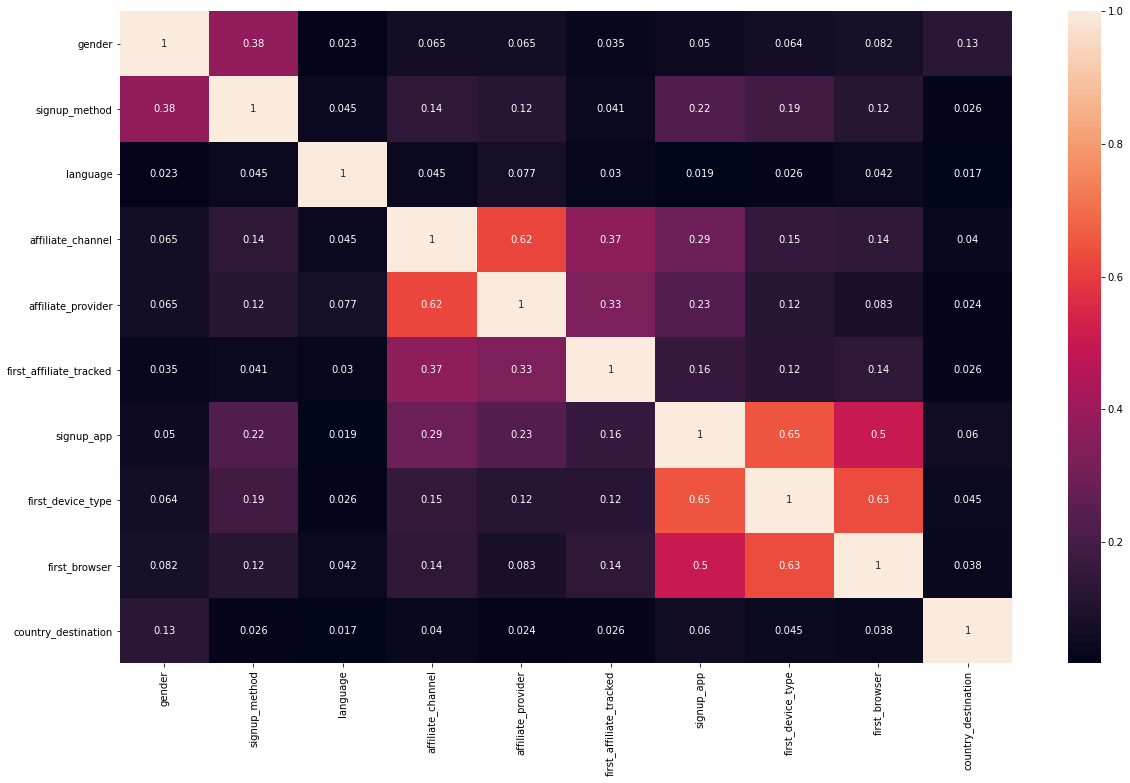

In [219]:
# list of attributes for cramer's v correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []
    ref = cat_attributes_list[i]
    for j in range(len(cat_attributes_list)):
        feat = cat_attributes_list[j]
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        corr_list.append(corr)

    corr_dict[ref] = corr_list
    
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

d =  pd.DataFrame(corr_dict)
d = d.set_index( d.columns )
sns.heatmap(d, annot = True, ax=ax)

#### 1.7.2.2. Sessions

In [220]:
cat_attributes_sessions = cat_attributes_sessions.drop('user_id', axis=1)
cat_attributes_sessions.describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


<AxesSubplot:>

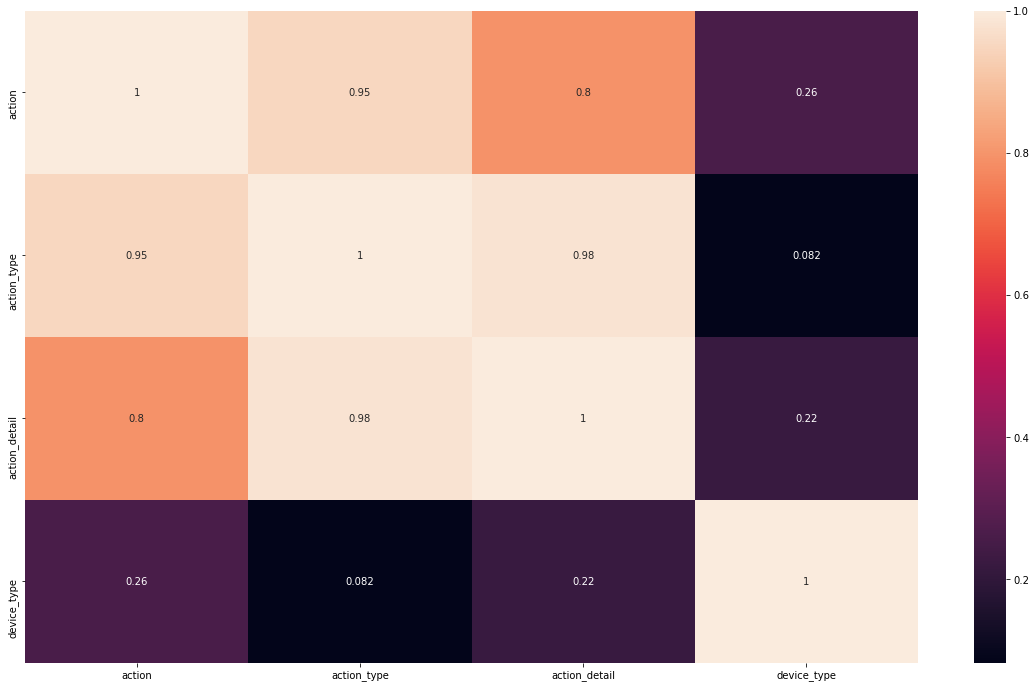

In [221]:
# list of attributes for cramer's v correlation
cat_attributes_list = cat_attributes_sessions.columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_list)):
    corr_list = []
    ref = cat_attributes_list[i]
    for j in range(len(cat_attributes_list)):
        feat = cat_attributes_list[j]
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        corr_list.append(corr)

    corr_dict[ref] = corr_list
    
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot()

d =  pd.DataFrame(corr_dict)
d = d.set_index( d.columns )
sns.heatmap(d, annot = True, ax=ax)

# 2.0 Feature Engineering

In [222]:
df2 = df1.copy()

## 2.1. Create New Features

In [223]:
# days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].apply(lambda x: x.date()))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).dt.days

# days from first active up to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).dt.days

# days from account created up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).dt.days

# ================================== First Active =========================================
# year of first active
df2['year_first_active'] = df2['first_active'].dt.year

# month of first active
df2['month_first_active'] = df2['first_active'].dt.month

# day of first active
df2['day_first_active'] = df2['first_active'].dt.day

# day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

# week of year of first active
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week
df2['week_of_year_first_active'] = df2['week_of_year_first_active'].astype(np.int64)


# ================================== Booking =========================================
# year of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

# month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

# day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

# day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

# week of year of first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.isocalendar().week
df2['week_of_year_first_booking'] = df2['week_of_year_first_booking'].astype(np.int64)


# ================================== Account Created =========================================
# year of account created
df2['year_account_created'] = df2['date_account_created'].dt.year

# month of account created
df2['month_account_created'] = df2['date_account_created'].dt.month

# day of account created
df2['day_account_created'] = df2['date_account_created'].dt.day

# day of week account created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

# week of year of account created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.isocalendar().week
df2['week_of_year_account_created'] = df2['week_of_year_account_created'].astype(np.int64)


In [224]:
df2.shape

(207386, 35)

# 3.0. Data Filtering

In [192]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [193]:
# age = greater than 15 and lower than 120
df3 = df3[(df3['age'] >15) & (df3['age'] < 120)]

# secs elapsed - there is no possible 0 secs elapsed on website
df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

## 3.2. Filtering Columns

In [194]:
# original datetime
cols = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] 
df3 = df3.drop(cols, axis=1)

# id
df3 = df3.drop(['id'], axis=1)

In [195]:
# High Correlation
cols = ['year_first_active', 'month_first_active', 'day_first_active', 'day_of_week_first_active',
 'week_of_year_first_active', 'month_first_booking', 'month_account_created', 
 'year_first_booking', 'affiliate_provider', 'first_browser', 'first_device_type']

df3 = df3.drop(cols , axis=1)

# 4.0. Balanced Dataset

In [197]:
df4 = df3.copy()
df4.shape

(206593, 19)

In [225]:
# Encoder Categorical Variables
ohe = pp.OneHotEncoder()

# Numerical
col_num = df4.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Categorical
col_cat = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']).drop(['country_destination'], axis=1).columns.tolist()

# encoding
df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index=df4.index)

# join numerical and catgorical
df42 = pd.concat([df4[col_num], df4_dummy], axis=1)
df42.shape

(206593, 63)

## 4.1. Random undersampling

In [226]:
# define sampler
undersampling = us.RandomUnderSampler(sampling_strategy = 'not minority', random_state = 32)

# apply samples
x_under, y_under = undersampling.fit_resample(df42, df4['country_destination'])

In [227]:
y_under.value_counts()

other    213
DE       213
IT       213
NL       213
NDF      213
CA       213
FR       213
ES       213
US       213
AU       213
PT       213
GB       213
Name: country_destination, dtype: int64

## 4.2. Random Oversampling

In [229]:
# define sampler
oversampling = overs.RandomOverSampler(sampling_strategy = 'all', random_state = 32)

# apply samples
x_over, y_over = oversampling.fit_resample(df42, df4['country_destination'])

In [230]:
y_over.value_counts()

AU       119810
NL       119810
FR       119810
IT       119810
NDF      119810
other    119810
GB       119810
DE       119810
CA       119810
PT       119810
ES       119810
US       119810
Name: country_destination, dtype: int64

## 4.3. SMOTE + TOMEKLINK

In [231]:
df4['country_destination'].value_counts().to_dict()

{'NDF': 119810,
 'US': 60800,
 'other': 9935,
 'FR': 4881,
 'IT': 2776,
 'GB': 2285,
 'ES': 2203,
 'CA': 1385,
 'DE': 1033,
 'NL': 746,
 'AU': 526,
 'PT': 213}

In [248]:
ratio_balanced =  {'NDF': 119810,
                    'US': 104968,
                    'other': 9935 *10,
                    'FR': 4881 * 21,
                    'IT': 2776 * 37,
                    'GB': 2285 * 45,
                    'ES': 2203 * 47,
                    'CA': 1385 * 75,
                    'DE': 1033 * 101,
                    'NL': 746 * 140,
                    'AU': 526 * 199,
                    'PT': 213 * 492}

In [249]:
# define sampler
smt_sampling = comb.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply samples
x_smt, y_smt = smt_sampling.fit_resample(df42, df4['country_destination'])

In [250]:
# numerical data
df43 = x_smt[col_num]

# categorical data
df44 = x_smt.drop(col_num, axis=1)
df45 = pd.DataFrame(ohe.inverse_transform(df44), columns=col_cat, index=df44.index)

# join numerical categorical
df46 = pd.concat([df43, df45], axis=1)
df46['country_destination'] = y_smt

df46.to_csv('../data/df46.csv', index=False)

In [278]:
df47 = pd.read_csv('../data/df46.csv')

# 5.0. Exploratory Data Analysis (EDA)

In [89]:
df51 = df47.copy()

In [90]:
df52 = df2.copy()

## 5.1. Bivariate Analysis - Hypothesis Validation (Unbalanced Dataset)

### **H01.** Em todos os destinos, os usuários levam 15 dias, em média, para fazerem a primeira reserva no Airbnb, desde a sua primeira ativação.

**Verdadeiro**, os usuários levam até 6 dias para reservar, em média. Foi utilizada a mediana, pois é menos sensível a outliers.

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

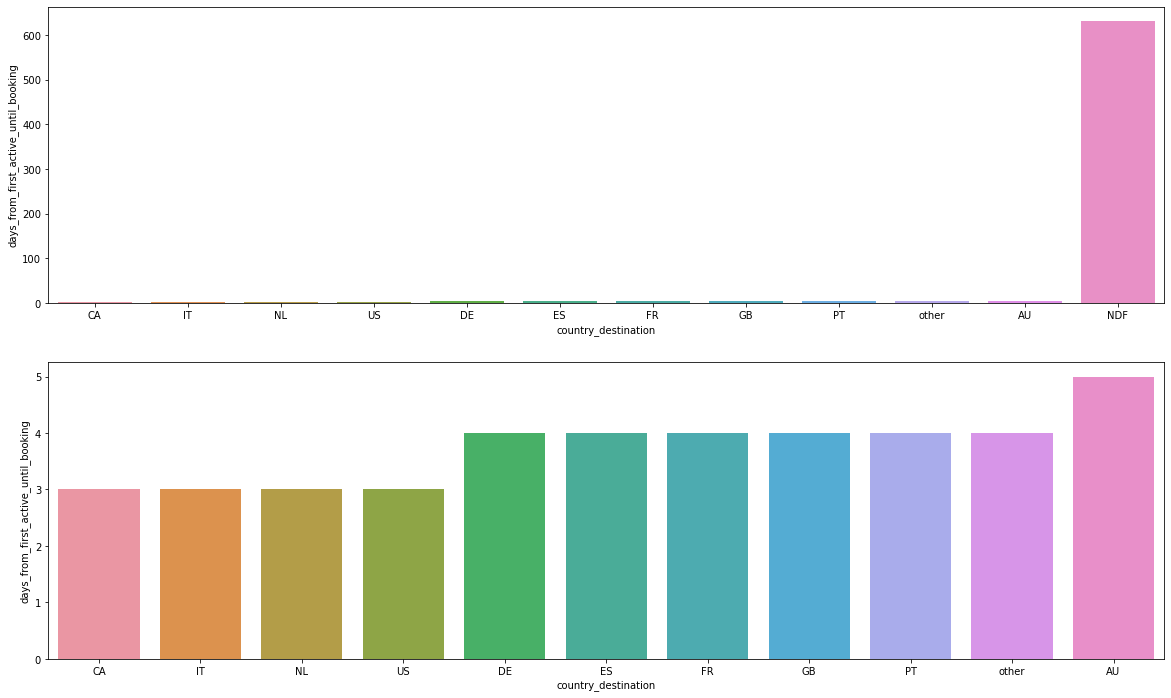

In [129]:
#define subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

aux01 = df52[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
            data=aux01.sort_values('days_from_first_active_until_booking'), ax=ax[0])

aux02 = df52[df52['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_booking', 
            data=aux02.sort_values('days_from_first_active_until_booking'), ax=ax[1])

### **H02.** Em todos os destinos os usuários levam até 3 dias, em média, para fazer o cadastro no site.

**Verdadeira**, em todos os destinos os usuários levam até 2 dias, em média, para efetivar o cadastro.

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_account_created'>

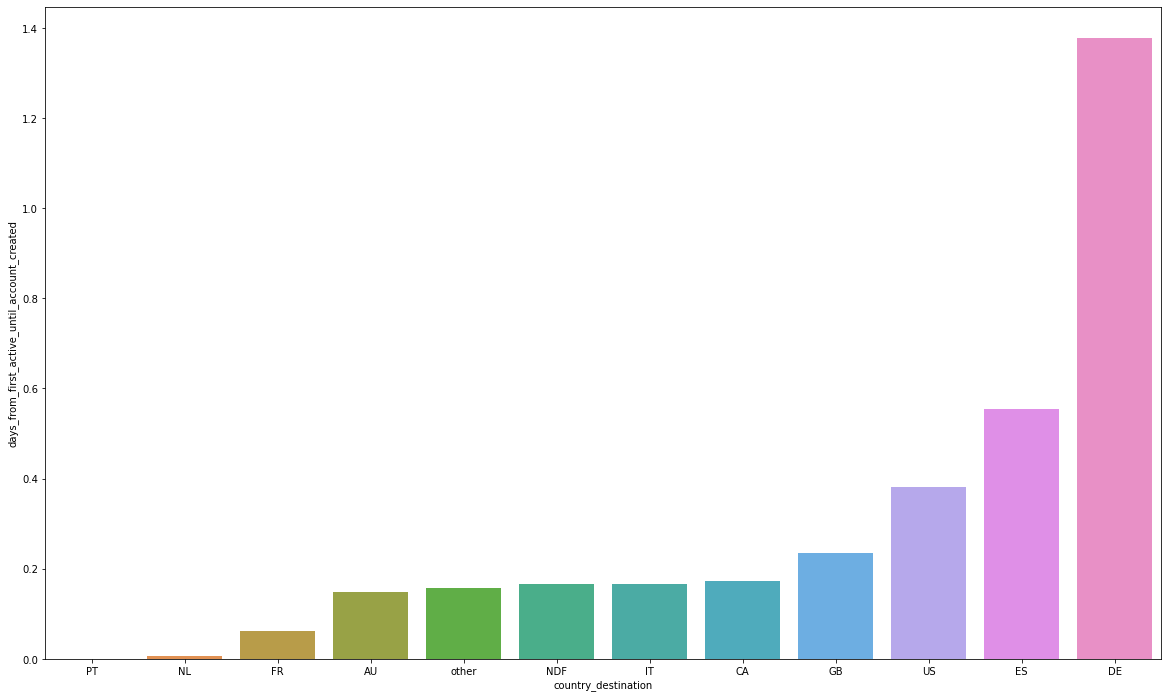

In [141]:
#define subplots
fig = plt.figure(figsize=(20,12))

aux01 = df52[['days_from_first_active_until_account_created', 'country_destination']].groupby('country_destination').mean().reset_index()
sns.barplot(x='country_destination', y='days_from_first_active_until_account_created', 
            data=aux01.sort_values('days_from_first_active_until_account_created'))



### **H03.** O volume de reservas anuais feitas durante o verão aumentaram 20% para destinos dentro dos USA.

**Falsa** O volume de reservas aumenta durante o verão entre os anos de 2010 e 2013 e diminui durante os anos posteriores.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta (%)'>

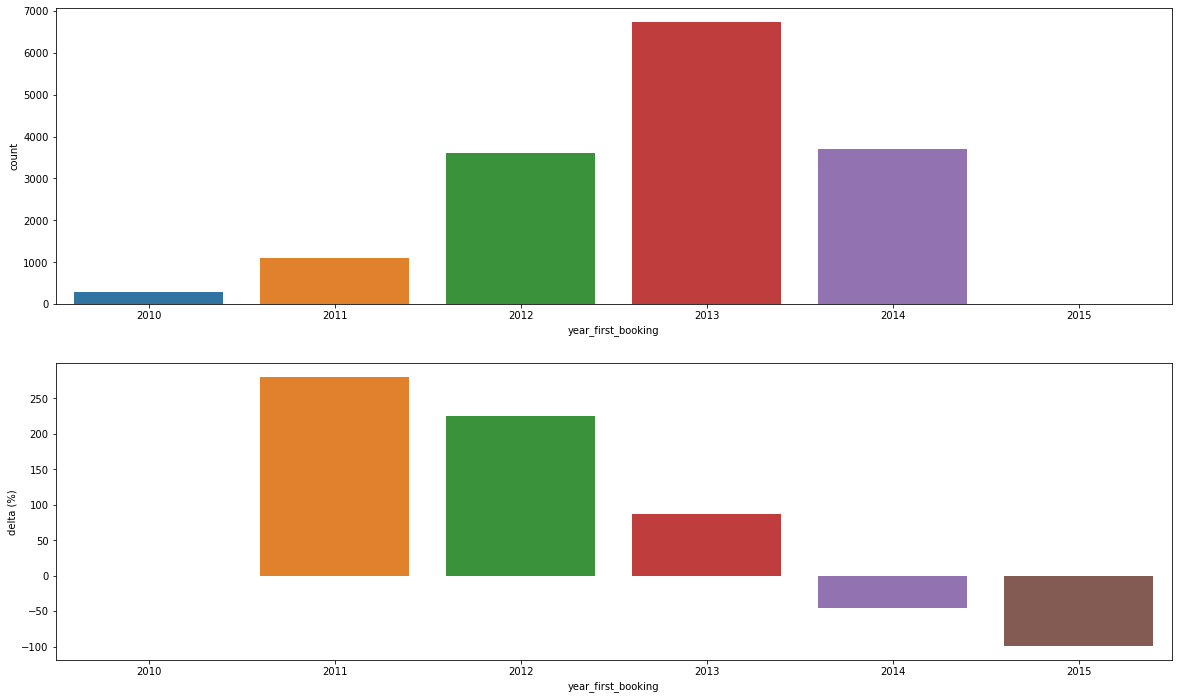

<Figure size 1440x864 with 0 Axes>

In [184]:
#define subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

# Summer lasts from June 21 until September 22,
aux01 = df52[df52['country_destination'] == 'US']
aux01 = aux01[((aux01['month_first_booking'] == 6) & (aux01['day_first_booking'] >= 21))  |
              ((aux01['month_first_booking'] >= 7) & (aux01['month_first_booking'] <= 8)) |
              ((aux01['month_first_booking'] == 9) & (aux01['day_first_booking'] <= 22))]

aux02 = aux01.groupby('year_first_booking').size().reset_index().rename(columns = {0: 'count'})

sns.barplot(x='year_first_booking', y='count', 
            data=aux02.sort_values('year_first_booking'), ax=ax[0])


aux02['delta (%)'] = 100 * aux02['count'].pct_change().fillna(0)
sns.barplot(x='year_first_booking', y='delta (%)', 
            data=aux02.sort_values('year_first_booking'), ax=ax[1])

### **H04.** Usuários do sexo feminino fazem mais de 10% mais reservas para países fora dos USA.

** Verdadeiro**, usuários do sexo feminino fazem 15% mais reservas para países fora dos USA

<AxesSubplot:xlabel='gender', ylabel='delta (%)'>

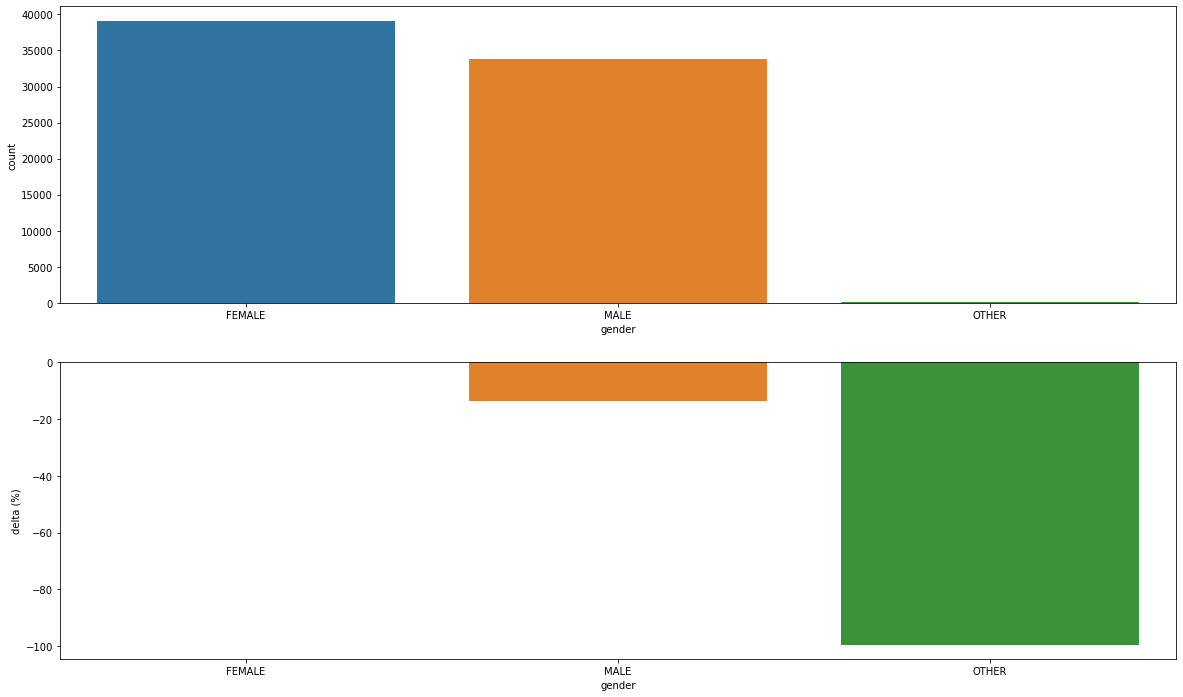

In [270]:
aux01 = df52[(df52['country_destination'] != 'US') & (df52['gender'] != '-unknown-')]

aux01 = aux01.groupby('gender').size().reset_index().rename(columns = {0: 'count'})

#define subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 12))

sns.barplot(x='gender', y='count', 
            data=aux01, ax=ax[0])

aux01['delta (%)'] = 100 * aux01['count'].pct_change().fillna(0)
sns.barplot(x='gender', y='delta (%)', 
            data=aux01, ax=ax[1])

### **H05.** O canal de Marketing Google representa 40% das reservas para países fora dos USA.

### **H06.** O destino dos USA representam mais de 20% em todos os canais.

### **H07.** A idade média das pessoas é de 35 anos em todos os destinos.

### **H08.** A percentagem de usuários que usam o site na língua inglês-americano para reservar acomodações em qualquer destino é maior qu 90%.

### **H09.** O número de reservas do airbnb é crescente ou decrescente ao ongo dos anos?

### **H10.** O número de reservas do AIRbnb é crescene ao longo dos anos

## 5.2. Variable Impact (Balanced Dataset)

In [188]:
profile = ProfileReport(df51, title='Airbnb Booking')
profile.to_file(output_file='airbnb_booking_statistics_after_filtering_columns.html')

Summarize dataset:  80%|████████  | 33/41 [00:14<00:03,  2.02it/s, Calculate kendall correlation]/home/leonam/anaconda3/envs/airbnb/lib/python3.8/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


In [ ]:
# High Correlation

# year_first_active x year_account_created
# remove: year_first_active

# month_first_active x month_account_created
# remove: month_first_active

# day_first_active x day_account_created
# remove: day_first_active

# day_of_week_first_active x day_of_week_account_created
# remove: day_of_week_first_active

# week_of_year_first_active x week_of_year_account_created
# remove: week_of_year_first_active

# month_first_booking x week_of_year_first_booking
# remove: month_first_booking

# month_account_created x week_of_year_account_created
# remove: month_account_created

# year_first_booking x year_account_created
# remove: year_first_booking

# ====================================================================================

# affiliate_provider x affiliate_channel
# remove: affiliate_provider (por possuir menos valores únicos)

# first_browser x first_device_type
# remove: first_browser (por possuir menos valores únicos)

# signup_app x first_device_type
# remove: first_device_type (por possuir menos valores únicos)

# 5.0. Data Preparation

In [279]:
df5 = df47.copy()

In [280]:
# dummy variable
df5_dummy = pd.get_dummies(df5.drop(['country_destination'], axis=1))

# join id and country destination
df5 = pd.concat([df5[['country_destination']], df5_dummy], axis=1)

# 6.0 Feature Selection

In [281]:
df6 = df5.copy()

# 7.0. Machine Learning Model

In [282]:
X = df6.drop('country_destination', axis=1)
y = df6[['country_destination']]

In [283]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

### Viés de Seleção: 

- Utilizando train_test_split posso "dar sorte" de selecionar uma boa amostra do meu conjunto de dados para treino e uma pessima amostra do conjunto de dados para teste

- Alguns comportamentos podem esar escondidos em amostras não selecionadas

- O comportamento dos dados de treino podem estar diferentes dos dados de teste


### Solução: 
- Amostrar o conjunto de dados mais vezes, para aumentar a chance do modelo aprender todos os padrões dos dados

### **Cross-Validation**

- K-Fold (5 a 10 folds)
- leave_one-Out -> super custoso mas garante que todos os possiveis padrões dos dados sejam vistos pelo modelo
- Não Funciona muito bem para séries temporais
- Não Funciona muito bem com dados desbalanceados

## 7.1.1. Baseline Model

In [284]:
country_destination_list = df6['country_destination'].drop_duplicates().sort_values().tolist()
country_destination_weights = df6['country_destination'].value_counts(normalize=True).sort_index().tolist()

# modelo que chuta de forma aleatória
yhat_random = random.choices(population=country_destination_list, 
                             k=len(y_test), 
                             weights= country_destination_weights)

Accuracy: 0.08312803715628644
Balanced Accuracy: 0.08295987826921288
Kappa Score: -0.00041769462848795236
              precision    recall  f1-score   support

          AU       0.08      0.08      0.08     20911
          CA       0.08      0.08      0.08     20678
          DE       0.09      0.09      0.09     21081
          ES       0.08      0.08      0.08     20587
          FR       0.08      0.08      0.08     20585
          GB       0.08      0.08      0.08     20524
          IT       0.08      0.08      0.08     20475
         NDF       0.09      0.10      0.09     23857
          NL       0.08      0.08      0.08     20889
          PT       0.08      0.08      0.08     20908
          US       0.08      0.08      0.08     21013
       other       0.08      0.08      0.08     19755

    accuracy                           0.08    251263
   macro avg       0.08      0.08      0.08    251263
weighted avg       0.08      0.08      0.08    251263



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

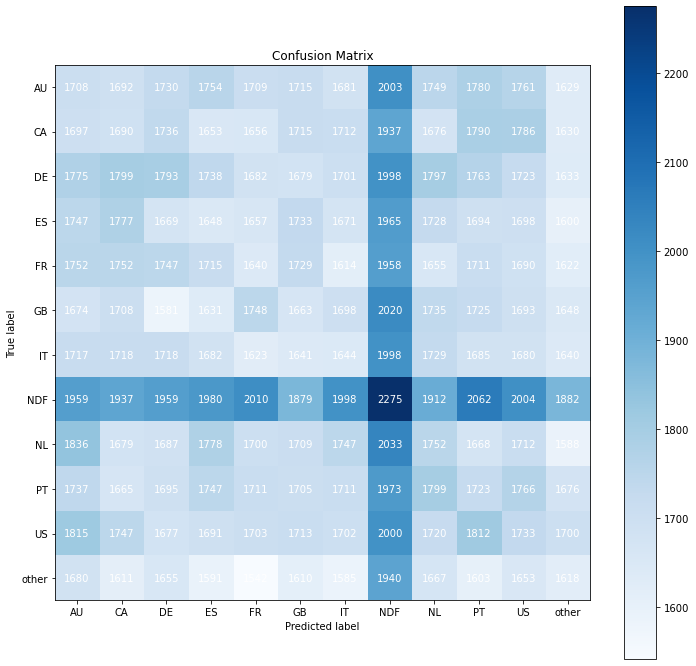

In [285]:
# Accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(m.classification_report(y_test, yhat_random, zero_division=0))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12,12))

## 7.1.2. Neral Network - MLP

In [286]:
# Categorically encode labels
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [287]:
# model definition
model = ml.Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(y_train['country_destination'].nunique(), activation='softmax'))

# model compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train model
model.fit(X_train, y_train_nn, epochs=10, verbose=1)

2021-10-23 22:18:44.925158: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-10-23 22:18:45.206027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-23 22:18:45.263698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.695GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-10-23 22:18:45.288944: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-10-23 22:18:45.604285: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-10-23 22:18:45.786237: I tensorflow/stream_executor/pla

Epoch 1/10


2021-10-23 22:19:06.723235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


1005050/1005050 [==============================] - 53s 53us/step - loss: 3.0716 - accuracy: 0.1943
Epoch 2/10
1005050/1005050 [==============================] - 44s 44us/step - loss: 2.1513 - accuracy: 0.2065
Epoch 3/10
1005050/1005050 [==============================] - 45s 45us/step - loss: 2.1478 - accuracy: 0.2092
Epoch 4/10
1005050/1005050 [==============================] - 45s 44us/step - loss: 2.1462 - accuracy: 0.2106
Epoch 5/10
1005050/1005050 [==============================] - 45s 45us/step - loss: 2.1457 - accuracy: 0.2113
Epoch 6/10
1005050/1005050 [==============================] - 45s 45us/step - loss: 2.1452 - accuracy: 0.2114
Epoch 7/10
1005050/1005050 [==============================] - 46s 45us/step - loss: 2.1449 - accuracy: 0.2120
Epoch 8/10
1005050/1005050 [==============================] - 50s 50us/step - loss: 2.1445 - accuracy: 0.2119
Epoch 9/10
1005050/1005050 [==============================] - 47s 47us/step - loss: 2.1440 - accuracy: 0.2123
Epoch 10/10
1005050/1

In [288]:
# prediction
pred_nn = model.predict(X_test)

# invert prediction
yhat_nn = np.ravel(ohe.inverse_transform(pred_nn))

# prediction prepare
y_test_nn = np.ravel(y_test.to_numpy())

Accuracy: 0.21216414673071643
Balanced Accuracy: 0.20112690706499012
Kappa Score: 0.13989846990506583
              precision    recall  f1-score   support

          AU       0.17      0.39      0.24     20911
          CA       0.11      0.26      0.15     20678
          DE       0.00      0.00      0.00     21081
          ES       0.09      0.01      0.01     20587
          FR       0.10      0.09      0.09     20585
          GB       0.00      0.00      0.00     20524
          IT       0.00      0.00      0.00     20475
         NDF       1.00      1.00      1.00     23857
          NL       0.00      0.00      0.00     20889
          PT       0.13      0.65      0.21     20908
          US       0.16      0.01      0.01     21013
       other       0.12      0.01      0.02     19755

    accuracy                           0.21    251263
   macro avg       0.16      0.20      0.14    251263
weighted avg       0.17      0.21      0.16    251263



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

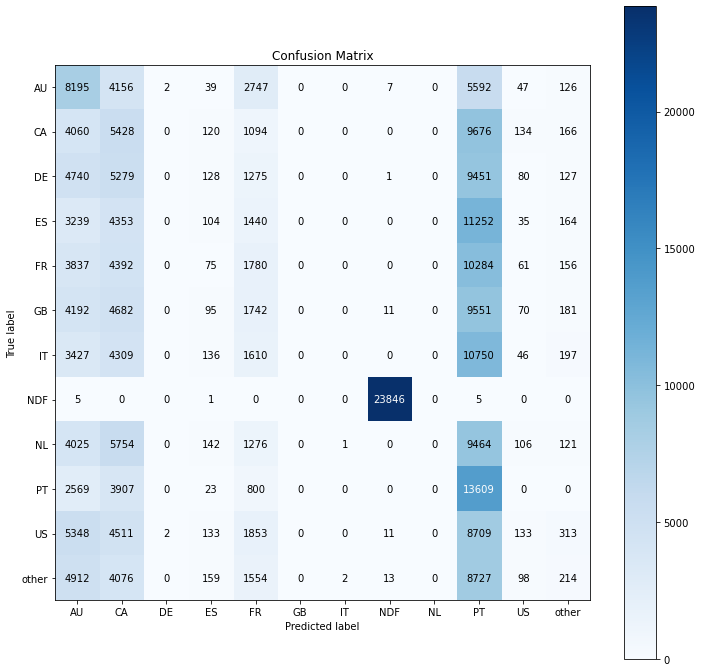

In [289]:
# Accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(m.classification_report(y_test_nn, yhat_nn, zero_division=0))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

## **O Problema:** 
A acurácia não é uma métrica ideal para representar a performance do modelo.

### **Possíveis Causas:**

* Falta de Features Representativas do Fenômeno;
* Dados com Ruídos ("Sujeira")
* Escasses de exemplos de treino para outras classes (dados desbalanceados).
* Divergência entre o Viés dos Dados eo Viés do Modelo (è o modelo mais adequado?)

## Métricas:

### Accuracy:  
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todas as <font color='blue'>Predições</font> <font color='blue'>Realizadas</font>  pelo modelo.


$$Acurácia = \frac{Número de Predições Corretas}{Número de Predições Realizadas}$$

$$Acurácia = \frac{9528}{13635} = 69.87\%$$

### Precision:  
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todas as <font color='blue'>Predições</font> <font color='blue'>Realizadas</font>  pelo modelo em cada Classe.


$$Acurácia = \frac{Número de Predições Corretas Classe FR}{Número de Predições Classe FR}$$

$$Acurácia = \frac{3}{26} = 11.54\%$$

- Métrica útil quando uma das classes do problema possui certa prioridade.

### Recall (Sensitividade): 
- Contar Quantas <font color='red'>**Predições**</font> foram <font color='red'>**Corretas**</font> e Dividir por todos os <font color='blue'>Exemplos Reais</font> de cada Classe.

$$Recall = \frac{Número de Predições Corretas Classe FR}{Total de Exemplos da Classe FR}$$

$$Recall = \frac{3}{710} = 0.42\%$$

### F1-Score: 
- Média entre Precision e Recall.
    - Média Harmônica

$$F1-Score = 2*\frac{Precision * Recall}{precision + Recall}$$

$$F1-Score = 2*\frac{0.115 * 0.004}{0.115 * 0.004} = 0.008 $$

- Calcula-se F1-score para cada uma das classes, sendo ideal para problemas de classificação binários. Para problemas multiclasse não é recomendável a utilização dessa métrica, pois terá que ser calculada para cada uma das classes.

## Precisamos de <font color='red'>uma ÚNICA Métrica</font> que diga a <font color='blue'>Performance</font> do Modelo.

### Balanced Accuracy: 
-Média das Acurácias de Cada Classe

$$Balanced Accuracy = \frac{1}{NClasses} \sum_{i=1}^{NClasses} \frac{PredCorretasClass_i}{TotalPredClass_i} $$

$$Balanced Accuracy = 9\%$$


### Kappa Score: 
-Médir o Nível de Acordo entre 2 Avaliadores

$$KappaScore= \frac{\#NidelDeAcordo - (\#NivelDeAcordoAoAcaso)}{1- \#NivelDeAcordoAoAcaso}  $$

$$NivelDeAcordoAoAcaso = Prob_A * Prob_B$$



## 7.3. NN Performance - Cross- Validation

In [ ]:
# generate k-fold
num_folds=5
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_score_list = []

i=1
for train_ix, val_ix in kfold.split(X_train, y_train):
    
    print('Fold Number {}/{}'.format(i, num_folds))
    # get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]

    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    # Categorically encode labels
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()

    # model definition
    model = ml.Sequential()
    model.add(Dense(256, input_dim=x_train_fold.shape[1], activation='relu'))
    model.add(Dense(11, activation='softmax'))

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=50, batch_size=32, verbose=0)

    # prediction
    pred_nn = model.predict(x_val_fold)

    # invert prediction
    yhat_nn = np.ravel(ohe.inverse_transform(pred_nn))
    y_val_nn = np.ravel(y_val_fold)
    
    # metrics
    # Balanced Accuracy
    balanced_acc_list.append(m.balanced_accuracy_score(y_val_nn, yhat_nn))

    # Kappa Metrics
    kappa_score_list.append(m.cohen_kappa_score(y_val_nn, yhat_nn))

    i+=1

pd.DataFrame({'Model Name':	'MLP', 
    'Balanced ACC CV': [str(np.round(np.mean(balanced_acc_list),2)) + ' +/- ' + str(np.round(np.std(balanced_acc_list),2))],
    'KAPPA SCORE CV': [str(np.round(np.mean(kappa_score_list),2)) + ' +/- ' + str(np.round(np.std(kappa_score_list),2))]})
